In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from dataset import Dacon
from model import *
from PIL import Image
from tqdm.auto import tqdm, trange
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

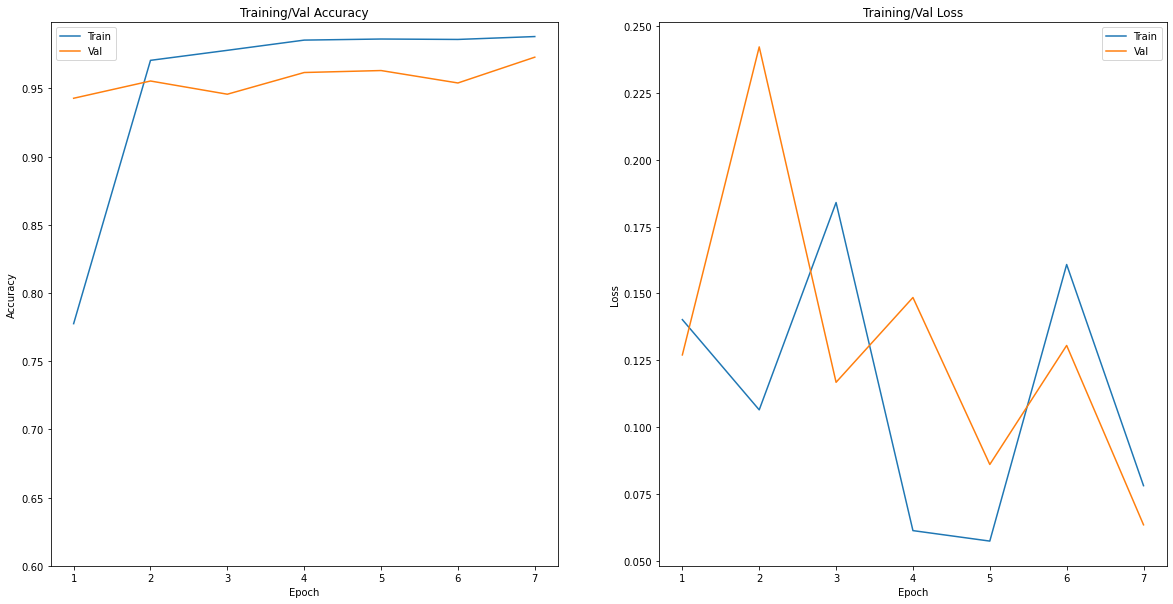

Train 정확도 : 0.988005, Train Loss : 0.078029
Val 정확도 : 0.972882, Val Loss : 0.063372 
가장 높은 Val 정확도 : 0.972882
현재 Epoch : 7


In [2]:
checkpoint = torch.load('./Lab_checkpoint.pt')
train_accuracy_list = checkpoint['train_accuracy']
train_loss_list = checkpoint['train_loss']
val_accuracy_list = checkpoint['val_accuracy']
val_loss_list = checkpoint['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Training/Val Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].plot(range(1, len(train_accuracy_list)+1), train_accuracy_list)
ax[0].plot(range(1, len(val_accuracy_list)+1), val_accuracy_list)
ax[0].legend(['Train', 'Val'])
#ax[0].set_xlim(left=15)
ax[0].set_ylim(bottom=0.6)

ax[1].set_title("Training/Val Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].plot(range(1, len(train_loss_list)+1), train_loss_list)
ax[1].plot(range(1, len(val_loss_list)+1), val_loss_list)
ax[1].legend(['Train', 'Val'])
#ax[1].set_xlim(left=15)
#ax[1].set_ylim(top=1.5)
plt.show()

print("Train 정확도 : %f, Train Loss : %f\nVal 정확도 : %f, Val Loss : %f " %(train_accuracy_list[-1], train_loss_list[-1], val_accuracy_list[-1], val_loss_list[-1]))
print("가장 높은 Val 정확도 : %f" %max(val_accuracy_list))
print("현재 Epoch : %d" %checkpoint['epoch'])